In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns

D:\Programs\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('S05-hw-dataset.csv')
df

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,51,131729,6,687,0.283093,3,1,1,0,13136,14209,0.251680,19,3,2,0
2996,2997,35,54454,36,634,0.396180,5,5,0,0,0,10858,0.506146,2,2,12,0
2997,2998,38,63305,16,573,0.577888,2,13,0,1,24870,6689,0.366375,16,2,10,1
2998,2999,42,55606,33,689,0.659278,6,9,1,0,32677,3252,0.295284,16,2,8,1


In [3]:
# Первичный анализ
print(df.head())
print(df.info())
print(df.describe())
print(df['default'].value_counts(normalize=True))

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

### **Краткий анализ**

**Данные:** 3000 наблюдений, 16 признаков, пропусков нет.

**Целевая переменная (дефолт):**  
- 59% - без дефолта (класс 0)  
- 41% - дефолт (класс 1)  
Задача умеренно несбалансирована.

**Ключевые характеристики клиентов:**  
- Средний возраст: 45 лет  
- Средний доход: ~70k  
- Средний кредитный скоринг: 649  
- Среднее количество просрочек: 7

In [4]:
# Удаляем client_id, так как это идентификатор
X = df.drop(['client_id', 'default'], axis=1)
y = df['default']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Бейзлайн-модель
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

print(f'Dummy Accuracy: {accuracy_score(y_test, y_pred_dummy)}')
print(f'Dummy ROC-AUC: {roc_auc_score(y_test, y_proba_dummy)}')

Dummy Accuracy: 0.59
Dummy ROC-AUC: 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best C: {'logreg__C': 10.0}
LogReg Accuracy: 0.8
LogReg ROC-AUC: 0.8756373156951908


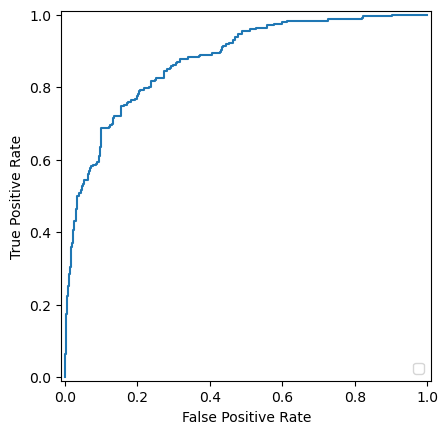

In [6]:
# Создаём pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор гиперпараметров
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

# Лучшая модель
best_model = grid.best_estimator_
y_pred_logreg = best_model.predict(X_test)
y_proba_logreg = best_model.predict_proba(X_test)[:, 1]

print(f'Best C: {grid.best_params_}')
print(f'LogReg Accuracy: {accuracy_score(y_test, y_pred_logreg)}')
print(f'LogReg ROC-AUC: {roc_auc_score(y_test, y_proba_logreg)}')

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba_logreg)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.savefig('figures/roc_curve.png')

In [7]:
# Таблица сравнения
results = pd.DataFrame({
    'Model': ['Dummy', 'Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, y_pred_dummy), accuracy_score(y_test, y_pred_logreg)],
    'ROC-AUC': [roc_auc_score(y_test, y_proba_dummy), roc_auc_score(y_test, y_proba_logreg)]
})

print(results)

                 Model  Accuracy   ROC-AUC
0                Dummy      0.59  0.500000
1  Logistic Regression      0.80  0.875637


In [8]:
y_pred_logreg_th05 = (y_proba_logreg >= 0.5).astype(int)
print("Метрики для порога 0.5:")
print(f"Precision: {precision_score(y_test, y_pred_logreg_th05):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg_th05):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_logreg_th05):.3f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_proba_logreg):.3f}")

Метрики для порога 0.5:
Precision: 0.794
Recall: 0.691
F1-score: 0.739
Average Precision Score: 0.840


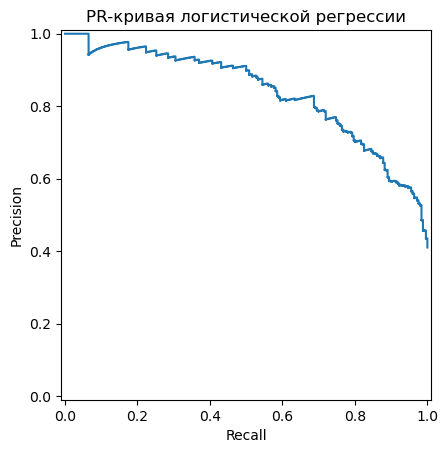

In [9]:
prec, recall, _ = precision_recall_curve(y_test, y_proba_logreg)
disp = PrecisionRecallDisplay(precision=prec, recall=recall)
disp.plot()
plt.title('PR-кривая логистической регрессии')
plt.savefig('figures/pr_curve.png')
plt.show()

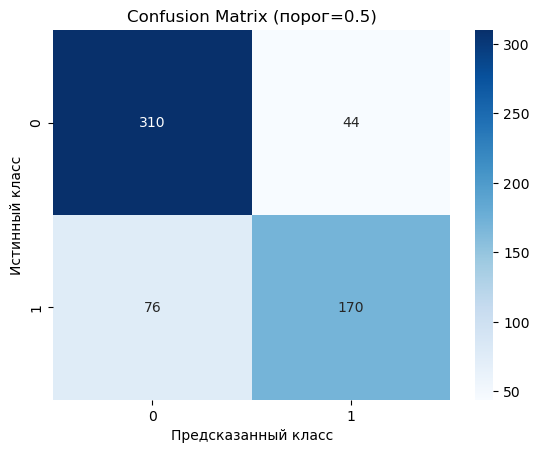

In [10]:
cm = confusion_matrix(y_test, y_pred_logreg_th05)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (порог=0.5)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.savefig('figures/confusion_matrix.png')
plt.show()

## **Итоги эксперимента**

### **Бейзлайн vs логистическая регрессия**
Бейзлайн-модель просто угадывает самый частый класс, что даёт accuracy 59% (совпадает с долей нулей в данных). Её ROC-AUC = 0.5 соответствует случайному угадыванию.

Логистическая регрессия показывает значительное улучшение:
- Accuracy выросла на 21% (с 0.59 до 0.80) - модель правильно предсказывает дефолт в 4 из 5 случаев
- ROC-AUC стал 0.876 - модель хорошо разделяет клиентов по риску
- Лучшая регуляризация: C=10 (слабая регуляризация, модель не переобучается)

### **Дополнительные метрики:**
- Precision (точность) = 0.794 - из всех предсказанных дефолтов 79.4% действительно дефолтные
- Recall (полнота) = 0.691 - модель находит 69.1% всех реальных дефолтов
- F1-score = 0.739 - баланс между точностью и полнотой
- Average Precision Score = 0.840 - высокое качество ранжирования при разных порогах

### **Анализ confusion matrix:**

- 310 правильных "не дефолтов" - модель хорошо идентифицирует надёжных клиентов
- 44 ложных срабатывания - клиентов без дефолта ошибочно пометили как рискованных
- 76 пропущенных дефолтов - каждый 4-й реальный дефолт не найден
- 170 правильно найденных дефолтов - основная часть дефолтов обнаружена

### **PR-кривая:**
PR-кривая показывает компромисс между точностью и полнотой. Значение 0.840 близко к 1, что подтверждает:
1. Модель сохраняет высокую точность даже при попытке найти больше дефолтов (высокий recall)
2. Кривая находится далеко от случайного уровня (горизонтальная линия на уровне доли дефолтов 0.41)

### **Практические выводы:**
1. Логистическая регрессия существенно лучше бейзлайна - признаки содержат полезную информацию для предсказания дефолта
2. ROC-AUC 0.876 и Average Precision 0.840 - отличные результаты для практического использования
3. Выбор между точностью и полнотой: 
   - При текущем пороге модель минимизирует ложные срабатывания (высокий precision)
   - При необходимости найти больше дефолтов можно снизить порог, пожертвовав точностью
4. Для этой задачи логистическая регрессия - простой и эффективный вариант, который даёт понятные результаты без лишней сложности.